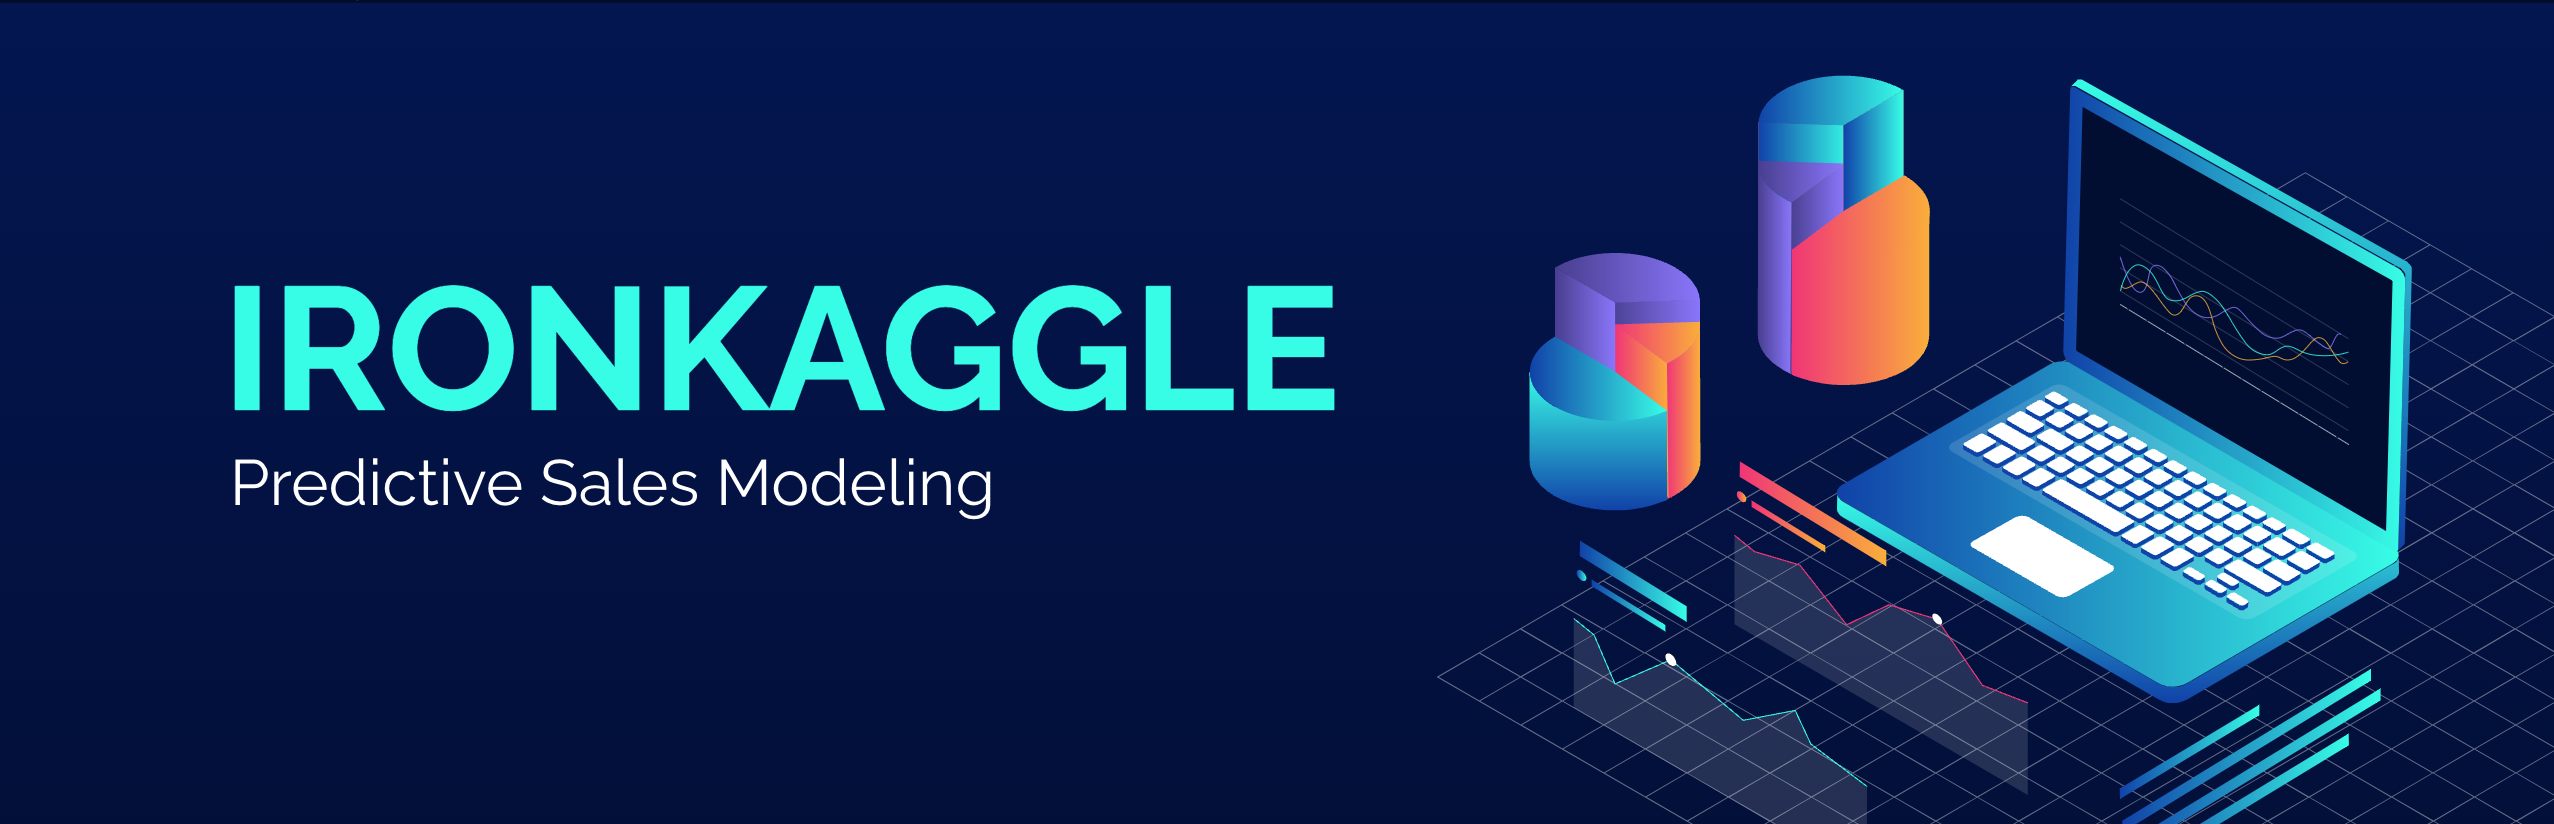

# 0 | Import Libraries

In [3]:
import pandas as pd                                                                         # Handling
import numpy as np

import matplotlib.pyplot as plt                                                             # Visualization
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder                # Preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score  # Train-Test Split & Model Selection
                             

from sklearn.linear_model import LinearRegression                                           # ML Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor


from sklearn.metrics import (                                                               # Metrics & Evaluation
    accuracy_score, precision_score, recall_score, f1_score, r2_score, 
    mean_absolute_error, mean_squared_error, root_mean_squared_error, classification_report, confusion_matrix
)

import pickle

# 1 | Load Data

In [5]:
def load_data(filepath):
    """Load dataset from CSV file"""
    return pd.read_csv(filepath)

df = load_data("validation_for students.csv")

# 2 | Explore Data

In [7]:
def explore_data(df):
    """Initial EDA"""
    print(df.info())
    display(df.head())
    print("\nSummary Statistics:")
    display(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum()/len(df)*100)
    print("\nDuplicated Values:")
    print(df.duplicated().sum())
    duplicates = df.duplicated().sum()
    percentage = df.duplicated().sum() / df.shape[0] * 100
    print(f'{duplicates} rows contain duplicates amounting to {percentage.round(2)}% of the total data.')
    print("\nLikely Target Value Counts:")
    print(df.iloc[:, -1].value_counts(normalize = True)*100)
    print (f"\nShape: {df.shape}")
    
explore_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                71205 non-null  int64 
 1   store_ID             71205 non-null  int64 
 2   day_of_week          71205 non-null  int64 
 3   date                 71205 non-null  object
 4   nb_customers_on_day  71205 non-null  int64 
 5   open                 71205 non-null  int64 
 6   promotion            71205 non-null  int64 
 7   state_holiday        71205 non-null  object
 8   school_holiday       71205 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 4.9+ MB
None


,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,272371,415,7,01/03/2015,0,0,0,0,0
1,558468,27,7,29/12/2013,0,0,0,0,0
2,76950,404,3,19/03/2014,657,1,1,0,0
3,77556,683,2,29/01/2013,862,1,0,0,0
4,456344,920,3,19/03/2014,591,1,1,0,0



Summary Statistics:


,index,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday
count,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000
mean,356303.922042,559.239857,4.000955,633.412387,0.830068,0.379735,0.179187
std,205672.881381,322.078792,1.997519,466.753188,0.375576,0.485324,0.383511
min,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,177497.000000,281.000000,2.000000,403.000000,1.000000,0.000000,0.000000
50%,356665.000000,557.000000,4.000000,609.000000,1.000000,0.000000,0.000000
75%,534811.000000,839.000000,6.000000,836.000000,1.000000,1.000000,0.000000
max,712027.000000,1115.000000,7.000000,5494.000000,1.000000,1.000000,1.000000



Missing Values:
index                  0.0
store_ID               0.0
day_of_week            0.0
date                   0.0
nb_customers_on_day    0.0
open                   0.0
promotion              0.0
state_holiday          0.0
school_holiday         0.0
dtype: float64

Duplicated Values:
0
0 rows contain duplicates amounting to 0.0% of the total data.

Likely Target Value Counts:
school_holiday
0    82.081315
1    17.918685
Name: proportion, dtype: float64

Shape: (71205, 9)


# 3 | Data Preprocessing

In [9]:
# df = df.drop(columns = ['open'])  # makes no sense to sell when store is closed

In [10]:
df.columns

Index(['index', 'store_ID', 'day_of_week', 'date', 'nb_customers_on_day',
       'open', 'promotion', 'state_holiday', 'school_holiday'],
      dtype='object')

In [11]:
column_mapping = {
    'index': 'true_index',
    'store_ID': 'store_id',
    'day_of_week': 'weekday',
    'date': 'date',
    'nb_customers_on_day':'customers_per_day',
    'open':'open',
    'promotion': 'promotion',
    'state_holiday': 'state_holiday',
    'school_holiday': 'school_holiday',    
}
df.rename(columns=column_mapping, inplace=True)
desired_order = ['true_index', 'store_id', 'date', 'weekday', 'state_holiday', 'school_holiday', 'open', 'promotion', 'customers_per_day']
df = df[desired_order]

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

In [13]:
df = pd.get_dummies(df, columns=['state_holiday'], dtype=int)

In [14]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day 
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71205 entries, 0 to 71204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   true_index         71205 non-null  int64         
 1   store_id           71205 non-null  int64         
 2   date               71205 non-null  datetime64[ns]
 3   weekday            71205 non-null  int64         
 4   school_holiday     71205 non-null  int64         
 5   open               71205 non-null  int64         
 6   promotion          71205 non-null  int64         
 7   customers_per_day  71205 non-null  int64         
 8   state_holiday_0    71205 non-null  int64         
 9   state_holiday_a    71205 non-null  int64         
 10  state_holiday_b    71205 non-null  int64         
 11  state_holiday_c    71205 non-null  int64         
 12  year               71205 non-null  int32         
 13  month              71205 non-null  int32         
 14  day   

In [16]:
desired_order = ['true_index','store_id', 'date', 'year','month','day','weekday','is_weekend', 'state_holiday_0', 'state_holiday_a','state_holiday_b','state_holiday_c', 'school_holiday', 'promotion', 'customers_per_day', 'open']
df = df[desired_order]

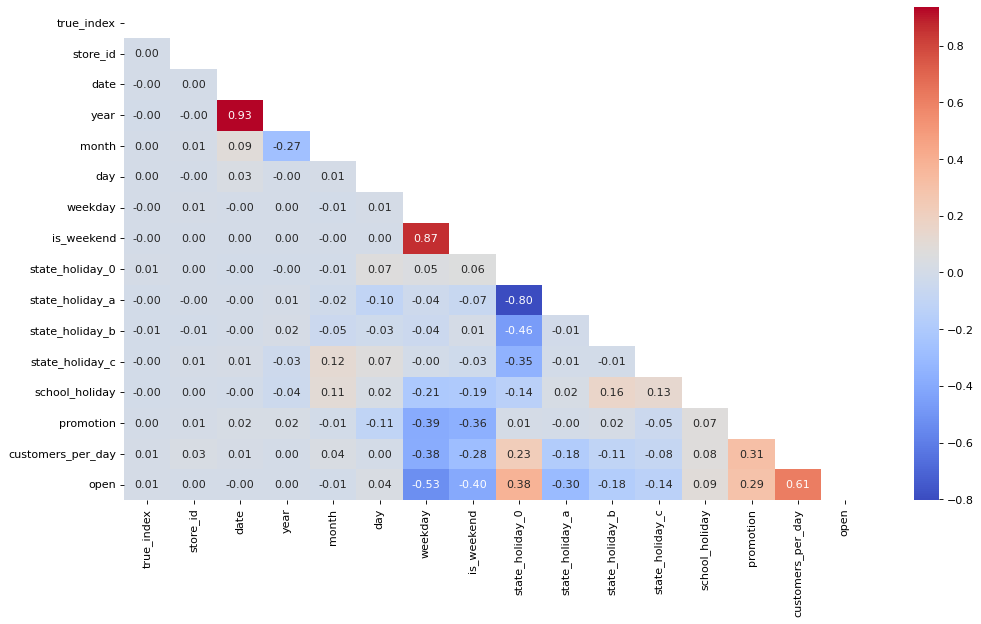

In [17]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(15,8), dpi=80) 
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap="coolwarm", fmt=".2f")
plt.show()

# 4 |  Importing & Testing Model 

In [19]:
with open('best_xgb_reg.pkl', 'rb') as f:
    best_xgb_reg = pickle.load(f)

In [20]:
df = df.drop(columns = ['date']) 

In [21]:
predictions = best_xgb_reg.predict(df)
predictions

array([  17.079863,  180.35794 , 6435.287   , ..., 5609.3696  ,
       6660.5073  , 7678.072   ], dtype=float32)

In [22]:
df = df.reset_index(drop=True) 
df["predicted_sales"] = predictions
df.loc[df["open"] == 0, "predicted_sales"] = 0
display(df.head())

,true_index,store_id,year,month,day,weekday,is_weekend,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,school_holiday,promotion,customers_per_day,open,predicted_sales
0,272371,415,2015,3,1,7,1,1,0,0,0,0,0,0,0,0.000000
1,558468,27,2013,12,29,7,1,1,0,0,0,0,0,0,0,0.000000
2,76950,404,2014,3,19,3,0,1,0,0,0,0,1,657,1,6435.287109
3,77556,683,2013,1,29,2,0,1,0,0,0,0,0,862,1,6557.404297
4,456344,920,2014,3,19,3,0,1,0,0,0,0,1,591,1,5731.615723


In [23]:
validations = df[["true_index", "predicted_sales"]]
validations

,true_index,predicted_sales
0,272371,0.000000
1,558468,0.000000
2,76950,6435.287109
3,77556,6557.404297
4,456344,5731.615723
...,...,...
71200,59062,0.000000
71201,687449,0.000000
71202,207393,5609.369629
71203,233378,6660.507324


In [43]:
df.to_csv("validations.csv")